In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import lightgbm as lgb
from scipy.stats import sem
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV as RSCV
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, make_scorer, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from scipy import interp
from scipy.stats import norm
from itertools import cycle


In [3]:
#All class data
new_risk_data = pd.read_csv(r'C:\Users\brian\Documents\Data-Science-Cap-2\CSV_Files\new_risk_data.csv')

X =pd.read_csv(r'C:\Users\brian\Documents\Data-Science-Cap-2\CSV_Files\X.csv')
y =pd.read_csv(r'C:\Users\brian\Documents\Data-Science-Cap-2\CSV_Files\y.csv')

X_test =pd.read_csv(r'C:\Users\brian\Documents\Data-Science-Cap-2\CSV_Files\X_test.csv')
X_train =pd.read_csv(r'C:\Users\brian\Documents\Data-Science-Cap-2\CSV_Files\X_train.csv')

y_test_all =pd.read_csv(r'C:\Users\brian\Documents\Data-Science-Cap-2\CSV_Files\y_test.csv')
y_train_all =pd.read_csv(r'C:\Users\brian\Documents\Data-Science-Cap-2\CSV_Files\y_train.csv')

In [4]:
y_test = y_test_all.values.ravel()
y_train = y_train_all.values.ravel()

<h1 style="color:blue"><b>Baseline Model </h1>

In [11]:
# Define the custom scoring metric
auc_scorer = make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr')

# Define the hyperparameter grid
param_grid = {'n_estimators': np.arange(100, 500, 50),
              'max_features': np.arange(0.1, 1, 0.1),
              'max_depth': [3, 5, 7, 9, 11, 13, 15],
              'max_samples': [0.3, 0.5, 0.8]}

# Create a RandomizedSearchCV object with cross-validation
base_model = RSCV(RandomForestClassifier(), param_grid, n_iter=100, cv=5, scoring=auc_scorer).fit(X_train, y_train)

# Get the best estimator and print its parameters
best_base_model = base_model.best_estimator_
print('Best model:', best_base_model)
print()


Best model: RandomForestClassifier(max_depth=15, max_features=0.2, max_samples=0.5,
                       n_estimators=350)



In [13]:
# Calculate and print the mean cross-validated AUC score
mean_auc = base_model.best_score_
print('Mean AUC score:', mean_auc)

# Predict probabilities on the test set
y_pred_proba = base_model.predict_proba(X_test)

# Calculate the AUC score for each class
auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

# Print the AUC score for each class
print('AUC score:', auc_score)

# Predict the class labels on the test set
y_pred = base_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

Mean AUC score: 0.8544158194924563
AUC score: 0.8529046577415426
              precision    recall  f1-score   support

           1       0.47      0.16      0.24      1241
           2       0.48      0.24      0.32      1310
           3       0.68      0.28      0.40       203
           4       0.60      0.67      0.63       286
           5       0.59      0.55      0.57      1086
           6       0.48      0.56      0.52      2247
           7       0.46      0.39      0.42      1606
           8       0.66      0.91      0.76      3898

    accuracy                           0.57     11877
   macro avg       0.55      0.47      0.48     11877
weighted avg       0.55      0.57      0.54     11877



<h1 style="color:blue"><b>All Class XGBoost </h1>

In [25]:
XG_y_train = y_train-1
XG_y_test = y_test-1


# Define the hyperparameter grid
XG_param_grid = {
    'n_estimators': np.arange(100, 500, 50),
    'max_depth': [3, 5, 7, 9, 11, 13, 15],
    'subsample': [0.3, 0.5, 0.8],
    'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
}

# Create a RandomizedSearchCV object with cross-validation
XG_all_model = RandomizedSearchCV(XGBClassifier(), XG_param_grid, n_iter=100, cv=5, scoring= auc_scorer)
XG_all_model.fit(X_train, XG_y_train)

# Get the best estimator and print its parameters
XG_all_best_model = XG_all_model.best_estimator_
print('Best model:', XG_all_best_model)
print()

# Evaluate the best model with 5-fold cross-validation and bootstrapping
XG_all_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)
XG_all_scores = cross_val_score(XG_all_best_model, X_train, XG_y_train, cv=XG_all_cv, scoring= auc_scorer)
print('Cross-validation AUC scores:', XG_all_scores)
print('Mean AUC score:', XG_all_scores.mean())
print()


# Get the probability estimates for each class
XG_all_y_pred_proba = XG_all_best_model.predict_proba(X_test)

# Calculate the AUC score using probabilities
XG_all_auc = roc_auc_score(XG_y_test, XG_all_y_pred_proba, multi_class='ovr')

print('AUC:', XG_all_auc)

Best model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

Cross-validation AUC scores: [0.86374207 0.86235054 0.86470162 0.86154319 0.86075781 0.86275474
 0.86607374 0.8636878  0.86414021 0.85530385 0.8610521  0.8664052
 0.86465946 0.85957724 0.86315591 0.86179809 0.86354518 0.86702024
 

In [42]:
std_error = np.std(XG_all_scores) / np.sqrt(len(XG_all_scores))

lower_bound = XG_all_scores.mean() - 1.96 * std_error
upper_bound = XG_all_scores.mean() + 1.96 * std_error

confidence_interval = (lower_bound, upper_bound)
print(confidence_interval)

(0.8615180768111198, 0.8637087351243712)


In [36]:
# Get the predictions
XG_all_y_pred = XG_all_best_model.predict(X_test)

# Print the classification report
classification_rep = classification_report(XG_y_test, XG_all_y_pred)
print('Classification Report:')
print(classification_rep)
print()

# Calculate the AUC score for each class
class_auc_scores = []
for i in range(8):
    class_auc = roc_auc_score(XG_y_test == i, XG_all_y_pred_proba[:, i])
    class_auc_scores.append(class_auc)

# Print individual AUC scores for each class
for i, auc_score in enumerate(class_auc_scores):
    print('Class {}: AUC = {:.2f}'.format(i+1, auc_score))

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.24      0.31      1241
           1       0.42      0.24      0.31      1310
           2       0.56      0.46      0.50       203
           3       0.62      0.67      0.64       286
           4       0.59      0.53      0.56      1086
           5       0.51      0.52      0.52      2247
           6       0.47      0.43      0.44      1606
           7       0.67      0.90      0.77      3898

    accuracy                           0.58     11877
   macro avg       0.54      0.50      0.51     11877
weighted avg       0.55      0.58      0.55     11877


Class 1: AUC = 0.78
Class 2: AUC = 0.76
Class 3: AUC = 0.95
Class 4: AUC = 0.95
Class 5: AUC = 0.88
Class 6: AUC = 0.82
Class 7: AUC = 0.84
Class 8: AUC = 0.91


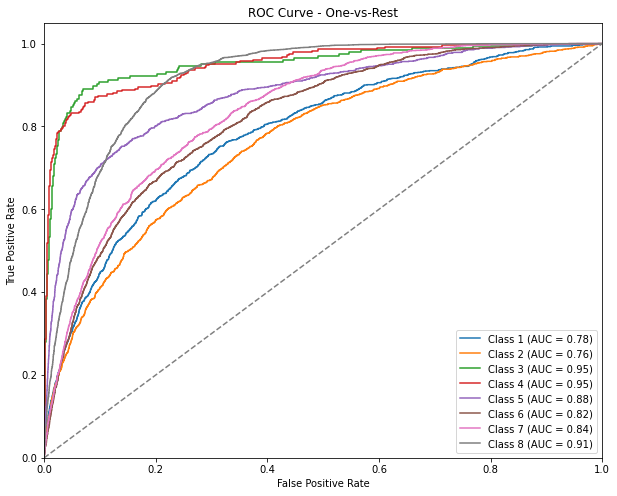

In [44]:
# Plot ROC curve and AUC for each class (One-vs-Rest strategy)
plt.figure(figsize=(10, 8))
for i in range(8):
    fpr, tpr, _ = roc_curve(XG_y_test == i, XG_all_y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='Class {} (AUC = {:.2f})'.format(i+1, roc_auc))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - One-vs-Rest')
plt.legend(loc='lower right')
plt.show()

<h1 style="color:blue"><b>LightGBM</h1>

<div style="color:blue"><b>Adjusting original dataset to meet the needs for LightGBM</b> </div>

In [2]:
# Load original dataset without one-hot encoded categorical variables
risk_data_v1=pd.read_csv(r"C:\Users\brian\Documents\Predicting Risk for Life Insurance Applications with LightGBM\Original Data\Risk Data.csv")

In [3]:
risk_data_v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59381 entries, 0 to 59380
Columns: 128 entries, Id to Response
dtypes: float64(18), int64(109), object(1)
memory usage: 58.0+ MB


In [4]:
# Drop variables with over 90% missing data
risk_data_v1.drop(['Medical_History_10', 'Medical_History_32', 'Medical_History_24'], axis=1, inplace=True)

In [5]:
# Fill NaN values with the mean for the selected variables
risk_data_v1['Employment_Info_1'].fillna(risk_data_v1['Employment_Info_1'].mean(), inplace=True)
risk_data_v1['Employment_Info_4'].fillna(risk_data_v1['Employment_Info_4'].mean(), inplace=True)
risk_data_v1['Medical_History_1'].fillna(risk_data_v1['Medical_History_1'].mean(), inplace=True)
risk_data_v1['Employment_Info_6'].fillna(risk_data_v1['Employment_Info_6'].mean(), inplace=True)
risk_data_v1['Insurance_History_5'].fillna(risk_data_v1['Insurance_History_5'].mean(), inplace=True)

In [6]:
# Fillinf NaN's with -999 for select variables
risk_data_v1['Family_Hist_5'].fillna(-999, inplace=True)
risk_data_v1['Family_Hist_3'].fillna(-999, inplace=True)
risk_data_v1['Family_Hist_2'].fillna(-999, inplace=True)
risk_data_v1['Family_Hist_4'].fillna(-999, inplace=True)
risk_data_v1['Medical_History_15'].fillna(-999, inplace=True)

In [7]:
from sklearn.preprocessing import MinMaxScaler
# create a scaler object
scaler = MinMaxScaler(feature_range=(0, 1))

# fit and transform the Family_Hist_4 variable
risk_data_v1['Family_Hist_4'] = scaler.fit_transform(risk_data_v1[['Family_Hist_4']])

In [8]:
# create the scaler object
scaler = MinMaxScaler()

# fit and transform the data
risk_data_v1[['Medical_History_1', 'Medical_History_15']] = scaler.fit_transform(risk_data_v1[['Medical_History_1', 'Medical_History_15']])

In [9]:
risk_data_v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59381 entries, 0 to 59380
Columns: 125 entries, Id to Response
dtypes: float64(15), int64(109), object(1)
memory usage: 56.6+ MB


<div style="color:blue"><b>Defining Categorical Variables </b></div>

In [10]:
object_cols = risk_data_v1.select_dtypes(include='object').columns.tolist()
object_cols

['Product_Info_2']

In [11]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
risk_data_v1['Product_Info_2_encoded'] = label_encoder.fit_transform(risk_data_v1['Product_Info_2'])

In [12]:
#list categorical variables
RD_cat_vars = ['Product_Info_1', 'Product_Info_2_encoded', 'Product_Info_3', 'Product_Info_5', 'Product_Info_6', 'Product_Info_7', 'Employment_Info_2', 'Employment_Info_3', 'Employment_Info_5', 'InsuredInfo_1', 'InsuredInfo_2', 'InsuredInfo_3', 'InsuredInfo_4', 'InsuredInfo_5', 'InsuredInfo_6', 'InsuredInfo_7', 'Insurance_History_1', 'Insurance_History_2', 'Insurance_History_3', 'Insurance_History_4', 'Insurance_History_7', 'Insurance_History_8', 'Insurance_History_9', 'Family_Hist_1', 'Medical_History_2', 'Medical_History_3', 'Medical_History_4', 'Medical_History_5', 'Medical_History_6', 'Medical_History_7', 'Medical_History_8', 'Medical_History_9', 'Medical_History_11', 'Medical_History_12', 'Medical_History_13', 'Medical_History_14', 'Medical_History_16', 'Medical_History_17', 'Medical_History_18', 'Medical_History_19', 'Medical_History_20', 'Medical_History_21', 'Medical_History_22', 'Medical_History_23', 'Medical_History_25', 'Medical_History_26', 'Medical_History_27', 'Medical_History_28', 'Medical_History_29', 'Medical_History_30', 'Medical_History_31', 'Medical_History_33', 'Medical_History_34', 'Medical_History_35', 'Medical_History_36', 'Medical_History_37', 'Medical_History_38', 'Medical_History_39', 'Medical_History_40', 'Medical_History_41']

In [13]:
#Setting variables to categorical
risk_data_v1[RD_cat_vars] = risk_data_v1[RD_cat_vars].astype('category')

In [14]:
# define the response variable and features
y_GBM = risk_data_v1['Response'].values 
X_GBM = risk_data_v1.drop(['Id', 'Response', 'Product_Info_2'], axis=1)

In [15]:
# Transform categorical features into the appropriate type that is eX_GBMpected by LightGBM
for c in X_GBM.columns:
    col_type = X_GBM[c].dtype
if col_type == 'object' or col_type.name == 'category':
    X_GBM[c] = X_GBM[c].astype('category')

<div style="color:blue"><b>Setting up LightGBM</b></div>

In [16]:
from sklearn.model_selection import train_test_split
#Train/test split
X_trainGBM, X_testGBM, y_trainGBM, y_testGBM = train_test_split(X_GBM, y_GBM, test_size=0.2, random_state=42, stratify= y_GBM )

In [17]:
print('length of X_trainGBM and x_testGBM: ', len(X_trainGBM), len(X_testGBM))
print('length of y_trainGBM and y_testGBM: ', len(y_trainGBM), len(y_testGBM))

length of X_trainGBM and x_testGBM:  47504 11877
length of y_trainGBM and y_testGBM:  47504 11877


In [18]:
auc_ovr = make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr')

In [19]:
# define the LightGBM model
GBM_model = lgb.LGBMClassifier(objective='multiclass', num_class=8, metric='None')

In [20]:
param_grid = {
    'scale_pos_weight': [1, 10, 100],
    'num_leaves': [20, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 10, -1],
    'reg_alpha': [0.1, 0.5, 1],
    'reg_lambda': [0.1, 0.5, 1],
}

In [21]:
# Define the LightGBM dataset
train_data = lgb.Dataset(X_trainGBM, label=y_trainGBM, categorical_feature=RD_cat_vars)

In [22]:
from sklearn.model_selection import RandomizedSearchCV
random_search_GBM = RandomizedSearchCV(GBM_model, param_distributions=param_grid, n_iter=10, cv=5, scoring=auc_ovr, random_state=42)
random_search_GBM.fit(X_trainGBM, y_trainGBM)

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(metric='None', num_class=8,
                                            objective='multiclass'),
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [5, 10, -1],
                                        'num_leaves': [20, 50, 100],
                                        'reg_alpha': [0.1, 0.5, 1],
                                        'reg_lambda': [0.1, 0.5, 1],
                                        'scale_pos_weight': [1, 10, 100]},
                   random_state=42,
                   scoring=make_scorer(roc_auc_score, needs_proba=True, multi_class=ovr))

In [23]:
# Get the best model
best_model_GBM = random_search_GBM.best_estimator_
best_model_GBM 

LGBMClassifier(learning_rate=0.05, max_depth=10, metric='None', num_class=8,
               num_leaves=50, objective='multiclass', reg_alpha=0.1,
               reg_lambda=0.5, scale_pos_weight=10)

In [24]:
import pickle

# Specify the path to the Models folder
models_folder = r'C:\Users\brian\Documents\Predicting Risk for Life Insurance Applications with LightGBM\Models\\'

# Save the best model to a file
with open(models_folder + 'best_model_GBM.pkl', 'wb') as file:
    pickle.dump(best_model_GBM, file)

In [25]:
# Evaluate the best model with 5-fold cross-validation and bootstrapping
best_model_GBM_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)
best_model_GBM_all_scores = cross_val_score(best_model_GBM , X_trainGBM, y_trainGBM, cv=best_model_GBM_cv, scoring= auc_ovr)
print('Cross-validation AUC scores:', best_model_GBM_all_scores)
print('Mean AUC score:', best_model_GBM_all_scores.mean())
print()

Cross-validation AUC scores: [0.86778867 0.86560258 0.86890459 0.86246984 0.86630248 0.86536115
 0.87126186 0.86628164 0.86603169 0.86201271 0.86495549 0.86887805
 0.86920157 0.86172739 0.86462589 0.86681177 0.86518625 0.87056669
 0.86669573 0.8622541  0.86922978 0.86197907 0.86981625 0.8618582
 0.86857753]
Mean AUC score: 0.8661752385584804



In [26]:
# Get the probability estimates for each class
GBM_y_pred_prob = best_model_GBM.predict_proba(X_testGBM)

# Calculate the AUC score using probabilities
GBM_all_auc = roc_auc_score(y_testGBM, GBM_y_pred_prob, multi_class='ovr')

print('AUC:', GBM_all_auc)

AUC: 0.8671837791643744


In [27]:
std_error = np.std(best_model_GBM_all_scores) / np.sqrt(len(best_model_GBM_all_scores))

lower_bound = best_model_GBM_all_scores.mean() - 1.96 * std_error
upper_bound = best_model_GBM_all_scores.mean() + 1.96 * std_error

confidence_interval = (lower_bound, upper_bound)
print(confidence_interval)

(0.8650416211663386, 0.8673088559506222)


In [28]:
# Get the predictions
GBM_y_pred = best_model_GBM.predict(X_testGBM)

# Print the classification report
classification_r = classification_report(y_testGBM, GBM_y_pred)
print('Classification Report:')
print(classification_r)

Classification Report:
              precision    recall  f1-score   support

           1       0.48      0.25      0.33      1241
           2       0.45      0.25      0.32      1310
           3       0.54      0.43      0.48       203
           4       0.60      0.67      0.64       286
           5       0.61      0.53      0.57      1086
           6       0.51      0.54      0.52      2247
           7       0.48      0.45      0.46      1606
           8       0.67      0.90      0.77      3898

    accuracy                           0.58     11877
   macro avg       0.54      0.50      0.51     11877
weighted avg       0.56      0.58      0.56     11877



In [29]:
# Get the unique classes from y_testGBM
unique_classes = np.unique(y_testGBM)

# Calculate the AUC score for each class
class_auc_scores = []
for i in range(len(unique_classes)):
    class_auc = roc_auc_score(y_testGBM == unique_classes[i], GBM_y_pred_prob[:, i])
    class_auc_scores.append(class_auc)

# Print individual AUC scores for each class
for i, auc_score in enumerate(class_auc_scores):
    print('Class {}: AUC = {:.2f}'.format(i+1, auc_score))

Class 1: AUC = 0.80
Class 2: AUC = 0.79
Class 3: AUC = 0.94
Class 4: AUC = 0.94
Class 5: AUC = 0.88
Class 6: AUC = 0.82
Class 7: AUC = 0.85
Class 8: AUC = 0.92


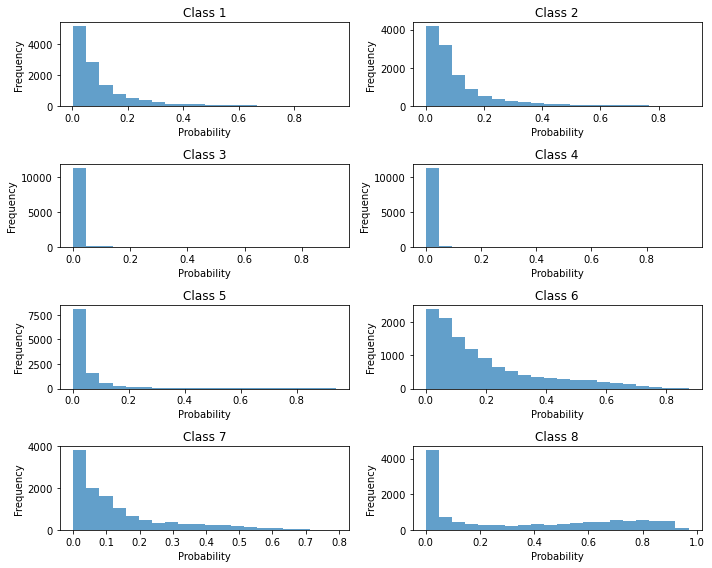

In [30]:
# Plot the probability distributions for each class
plt.figure(figsize=(10, 8))
for i in range(8):
    plt.subplot(4, 2, i+1)
    plt.hist(GBM_y_pred_prob[:, i], bins=20, alpha=0.7)
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.title('Class {}'.format(i+1))
plt.tight_layout()
plt.show()

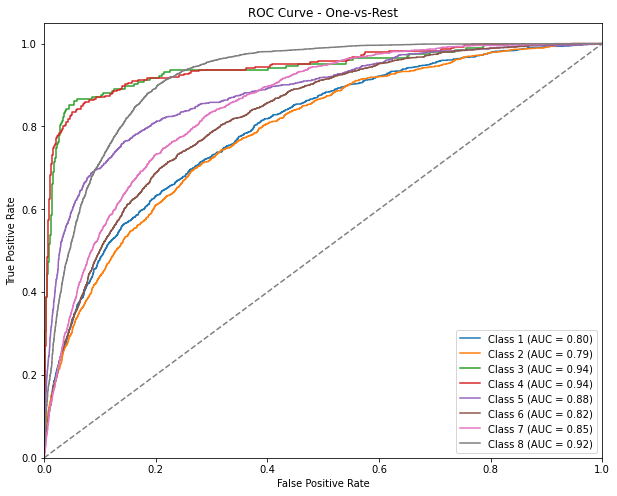

In [31]:
# Plot ROC curve and AUC for each class (One-vs-Rest strategy)
plt.figure(figsize=(10, 8))
for i in range(8):
    fpr, tpr, _ = roc_curve(y_testGBM == unique_classes[i], GBM_y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='Class {} (AUC = {:.2f})'.format(i+1, roc_auc))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - One-vs-Rest')
plt.legend(loc='lower right')
plt.show()

In [32]:
from sklearn.metrics import cohen_kappa_score

# Get the predictions
GBM_y_pred = best_model_GBM.predict(X_testGBM)

# Calculate the quadratic weighted kappa score
kappa_score = cohen_kappa_score(y_testGBM, GBM_y_pred, weights='quadratic')
print("Quadratic Weighted Kappa Score:", kappa_score)

Quadratic Weighted Kappa Score: 0.5554427168502972


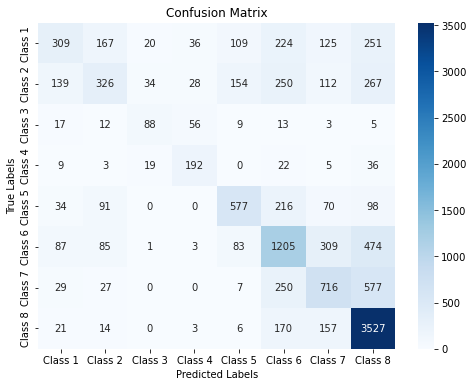

In [33]:
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_testGBM, GBM_y_pred)

# Define class labels
class_labels = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

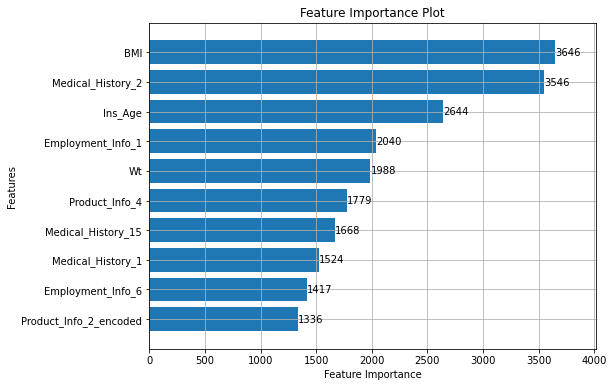

In [34]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(8, 6))
lgb.plot_importance(best_model_GBM, ax=ax, max_num_features=10, height=0.8)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Plot')
plt.show()

<h1 style="color:blue"><b>LightGBM with SMOTE and Undersample Class 8</h1>

In [35]:
# Calculate the number of samples for class 8
class_8_count = np.sum(y_trainGBM == 8)

# Print the count for class 8
print("Class 8 count:", class_8_count)

Class 8 count: 15591


In [36]:
# Calculate the number of samples for class 8
class_6_count = np.sum(y_trainGBM == 6)

# Print the count for class 8
print("Class 6 count:", class_6_count)

Class 6 count: 8986


In [37]:
# Print the total count for all classes
total_count = len(y_trainGBM)
print("Total count:", total_count)

Total count: 47504


In [38]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Apply SMOTE to minority classes
smote = SMOTE(random_state=42)
X_trainGBM_resampled, y_trainGBM_resampled = smote.fit_resample(X_trainGBM, y_trainGBM)

# Undersample class 8
desired_sample_size = 9000
undersampler = RandomUnderSampler(sampling_strategy={8: desired_sample_size}, random_state=42)
X_trainGBM_resampled, y_trainGBM_resampled = undersampler.fit_resample(X_trainGBM_resampled, y_trainGBM_resampled)

In [39]:
# Train/test split with the resampled data
X_trainGBM_resampled, X_testGBM, y_trainGBM_resampled, y_testGBM = train_test_split(X_trainGBM_resampled, y_trainGBM_resampled, test_size=0.2, random_state=42)

# Define the LightGBM dataset
train_data_resampled = lgb.Dataset(X_trainGBM_resampled, label=y_trainGBM_resampled, categorical_feature=RD_cat_vars)

# Perform the model training with the resampled data
random_search_GBM.fit(X_trainGBM_resampled, y_trainGBM_resampled)

# Make predictions on the test set
GBM_y_pred = random_search_GBM.predict(X_testGBM)
GBM_y_pred_prob = random_search_GBM.predict_proba(X_testGBM)

In [40]:
# Get the best model
best_model_GBM_SMOTE = random_search_GBM.best_estimator_
best_model_GBM_SMOTE

LGBMClassifier(learning_rate=0.05, metric='None', num_class=8, num_leaves=100,
               objective='multiclass', reg_alpha=0.5, reg_lambda=0.1,
               scale_pos_weight=1)

In [41]:
# Save the best model to a file
with open(models_folder + 'best_model_GBM_SMOTE.pkl', 'wb') as file:
    pickle.dump(best_model_GBM_SMOTE, file)

In [55]:
# Evaluate the best model with 5-fold cross-validation and bootstrapping
best_model_GBMS_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)
best_model_GBMS_all_scores = cross_val_score(best_model_GBM_SMOTE, X_trainGBM_resampled, y_trainGBM_resampled, cv=best_model_GBMS_cv, scoring='roc_auc_ovr')
print('Cross-validation AUC scores:', best_model_GBM_all_scores)
print('Mean AUC score:', best_model_GBMS_all_scores.mean())
print()

Cross-validation AUC scores: [0.93172992 0.93093984 0.93269115 0.93127103 0.93276835 0.93050545
 0.93389797 0.93281024 0.93278979 0.93069957 0.93214975 0.93096041
 0.93249906 0.93127146 0.93379785 0.93221116 0.93444325 0.93124907
 0.93035746 0.93241448 0.93248779 0.93189297 0.93213877 0.93042656
 0.93388789]
Mean AUC score: 0.9320916495197054



In [58]:
mean_auc = best_model_GBMS_all_scores.mean()
std_err = np.std(best_model_GBMS_all_scores) / np.sqrt(len(best_model_GBMS_all_scores))
z_value = 1.96  # For a 95% confidence interval (assuming normal distribution)

lower_bound = mean_auc - z_value * std_err
upper_bound = mean_auc + z_value * std_err

confidence_interval = (lower_bound, upper_bound)
print('Confidence Interval:', confidence_interval)

Confidence Interval: (0.9316463189000662, 0.9325369801393445)


In [56]:
# Get the probability estimates for each class
GBMS_y_pred_prob = best_model_GBM_SMOTE.predict_proba(X_testGBM)

# Calculate the AUC score using probabilities
GBMS_all_auc = roc_auc_score(y_testGBM, GBMS_y_pred_prob, multi_class='ovr')

print('AUC:', GBMS_all_auc)

AUC: 0.9347231885081919


In [59]:
from sklearn.metrics import classification_report

# Get the predictions
GBMS_y_pred = best_model_GBM_SMOTE.predict(X_testGBM)

# Print the classification report
report_GBMSMOTE = classification_report(y_testGBM, GBMS_y_pred)
print('Classification Report:')
print(report_GBMSMOTE)

Classification Report:
              precision    recall  f1-score   support

           1       0.64      0.55      0.59      3190
           2       0.59      0.47      0.53      3110
           3       0.90      0.91      0.91      3175
           4       0.88      0.95      0.91      3159
           5       0.70      0.68      0.69      3116
           6       0.56      0.51      0.53      3034
           7       0.57      0.67      0.62      3112
           8       0.59      0.81      0.68      1732

    accuracy                           0.69     23628
   macro avg       0.68      0.69      0.68     23628
weighted avg       0.69      0.69      0.68     23628



In [61]:
# Get the unique classes
classes = np.unique(y_testGBM)

# Calculate the AUC score for each class
auc_scores = []
for cls in classes:
    # Create a binary label for the current class
    binary_labels = np.where(y_testGBM == cls, 1, 0)
    
    # Calculate the AUC score for the current class
    auc = roc_auc_score(binary_labels, GBMS_y_pred_prob[:, cls - 1], multi_class='ovr')
    
    # Append the AUC score to the list
    auc_scores.append(auc)

# Print the AUC scores for each class
for cls, auc in zip(classes, auc_scores):
    print(f'Class {cls}: AUC = {auc}')

Class 1: AUC = 0.894958174597015
Class 2: AUC = 0.8800607983140205
Class 3: AUC = 0.9925688047611367
Class 4: AUC = 0.9929963965768788
Class 5: AUC = 0.9293315450525595
Class 6: AUC = 0.8877384367220386
Class 7: AUC = 0.9244125752250048
Class 8: AUC = 0.975718776816882


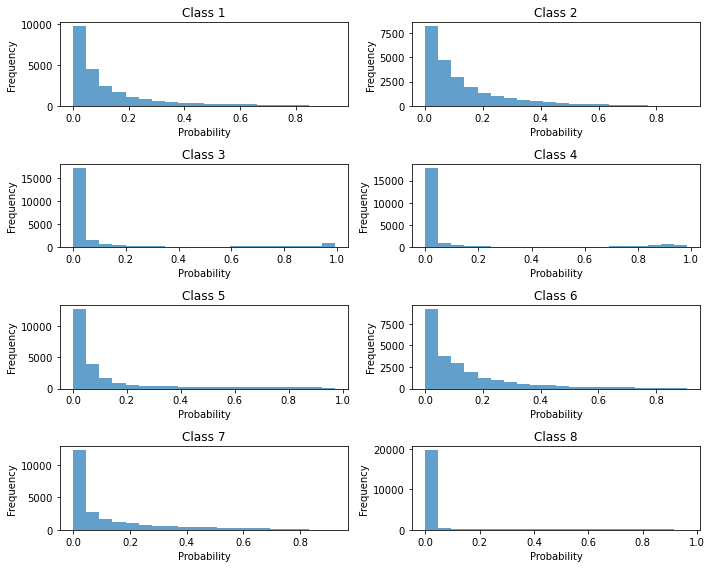

In [62]:
# Plot the probability distributions for each class
plt.figure(figsize=(10, 8))
for i in range(8):
    plt.subplot(4, 2, i+1)
    plt.hist(GBMS_y_pred_prob[:, i], bins=20, alpha=0.7)
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.title('Class {}'.format(i+1))
plt.tight_layout()
plt.show()

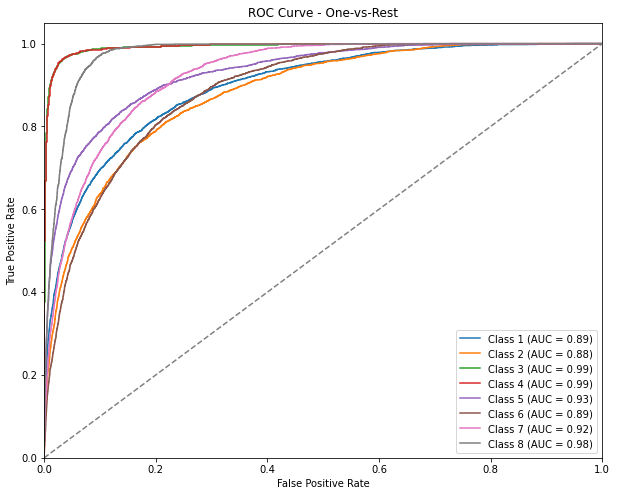

In [64]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Plot ROC curve and AUC for each class (One-vs-Rest strategy)
plt.figure(figsize=(10, 8))
for i in range(8):
    fpr, tpr, _ = roc_curve(y_testGBM == unique_classes[i], GBMS_y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='Class {} (AUC = {:.2f})'.format(i+1, roc_auc))

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - One-vs-Rest')
plt.legend(loc='lower right')
plt.show()

In [65]:
# Quadratic Weighted Kappa Score
# Calculate the quadratic weighted kappa score
kappa_score = cohen_kappa_score(y_testGBM, GBMS_y_pred, weights='quadratic')
print("Quadratic Weighted Kappa Score:", kappa_score)

Quadratic Weighted Kappa Score: 0.6461515371734279


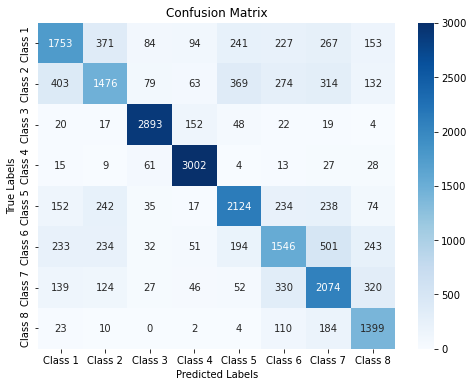

In [66]:
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_testGBM, GBMS_y_pred)

# Define class labels
class_labels = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

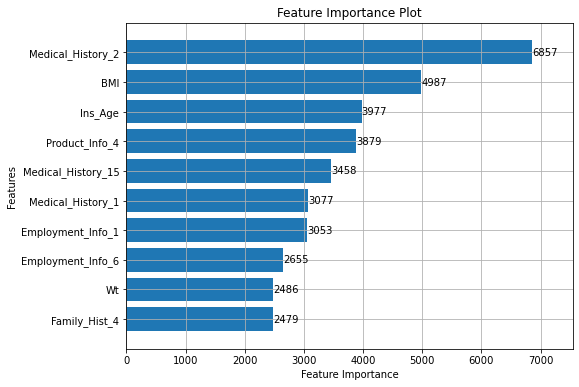

In [68]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(8, 6))
lgb.plot_importance(best_model_GBM_SMOTE, ax=ax, max_num_features=10, height=0.8)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance Plot')
plt.show()

In [83]:
# Get the feature names from the model
feature_names = best_model_GBM_SMOTE.feature_name_
# Get the model parameters
model_params = best_model_GBM_SMOTE.get_params()
# Calculate the accuracy score
accuracy = 0.69

In [84]:
import csv

# Define the model metrics
model_metrics = {
    'Model Name': 'best_model_GBM_SMOTE',
    'Features': feature_names, 
    'Parameters': model_params,    
    'Performance Metrics': {
        'AUC': GBMS_all_auc,  
        'Accuracy': accuracy ,  
    }
}

# Specify the file path
file_path = r"C:\Users\brian\Documents\Predicting Risk for Life Insurance Applications with LightGBM\Model Metrics\model_metrics.csv"

# Write the model metrics to the file
with open(file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the header row
    writer.writerow(['Model Name', 'Features', 'Parameters', 'Hyperparameters', 'AUC', 'Accuracy'])
    
    # Write the data rows
    writer.writerow([
        model_metrics['Model Name'],
        model_metrics['Features'],
        model_metrics['Parameters'],
        model_metrics['Performance Metrics']['AUC'],
        model_metrics['Performance Metrics']['Accuracy']
    ])
    
print("Model metrics saved successfully.")

Model metrics saved successfully.


In [85]:
# Print the model metrics
print('Model Metrics:')
print('Model Name:', model_metrics['Model Name'])
print('Features:', model_metrics['Features'])
print('Parameters:', model_metrics['Parameters'])
print('AUC:', model_metrics['Performance Metrics']['AUC'])
print('Accuracy:', model_metrics['Performance Metrics']['Accuracy'])

Model Metrics:
Model Name: best_model_GBM_SMOTE
Features: ['Product_Info_1', 'Product_Info_3', 'Product_Info_4', 'Product_Info_5', 'Product_Info_6', 'Product_Info_7', 'Ins_Age', 'Ht', 'Wt', 'BMI', 'Employment_Info_1', 'Employment_Info_2', 'Employment_Info_3', 'Employment_Info_4', 'Employment_Info_5', 'Employment_Info_6', 'InsuredInfo_1', 'InsuredInfo_2', 'InsuredInfo_3', 'InsuredInfo_4', 'InsuredInfo_5', 'InsuredInfo_6', 'InsuredInfo_7', 'Insurance_History_1', 'Insurance_History_2', 'Insurance_History_3', 'Insurance_History_4', 'Insurance_History_5', 'Insurance_History_7', 'Insurance_History_8', 'Insurance_History_9', 'Family_Hist_1', 'Family_Hist_2', 'Family_Hist_3', 'Family_Hist_4', 'Family_Hist_5', 'Medical_History_1', 'Medical_History_2', 'Medical_History_3', 'Medical_History_4', 'Medical_History_5', 'Medical_History_6', 'Medical_History_7', 'Medical_History_8', 'Medical_History_9', 'Medical_History_11', 'Medical_History_12', 'Medical_History_13', 'Medical_History_14', 'Medical_His

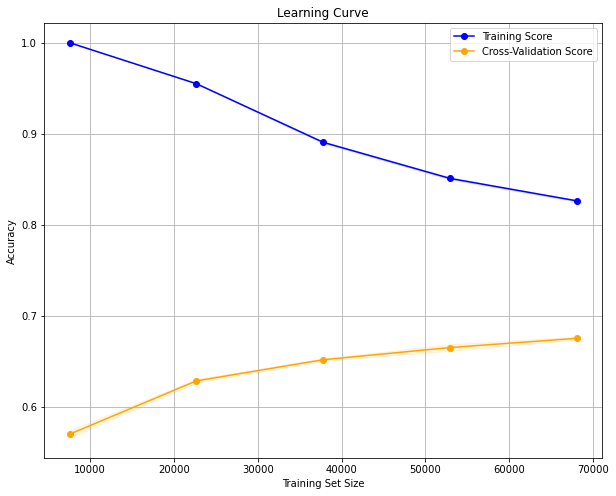

In [89]:
from sklearn.model_selection import learning_curve

# Define your model (replace "model" with your actual model)
model = best_model_GBM_SMOTE

# Define the learning curve parameters
train_sizes = [0.1, 0.3, 0.5, 0.7, 0.9]  # Fraction of the training set to be used for each point on the learning curve

# Calculate the learning curve scores
train_sizes, train_scores, test_scores = learning_curve(model, X_trainGBM_resampled, y_trainGBM_resampled, cv=5, train_sizes=train_sizes, scoring='accuracy')

# Calculate the mean and standard deviation of the training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 8))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='orange')
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training Score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='orange', label='Cross-Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

<div style="color:blue"><b>Final Notes:</b> Overall Performance: Considering the presence of large class imbalances, the model performs decently. It consistently classifies classes 3 and 4 accurately, while classes 1, 2, and 6 show some difficulty with misclassification.

Learning Curve: The learning curve graph indicates that increasing the training data size does not lead to a significant improvement in accuracy. The accuracy score stabilizes and becomes more realistic as the training set size increases, suggesting that the model has sufficient training data.

Final Report: For a comprehensive analysis and detailed explanations of the model's findings, please refer to the final report. It provides a thorough examination of the model's performance and insights into its strengths and limitations. </div>